cuda


<IPython.core.display.Javascript object>


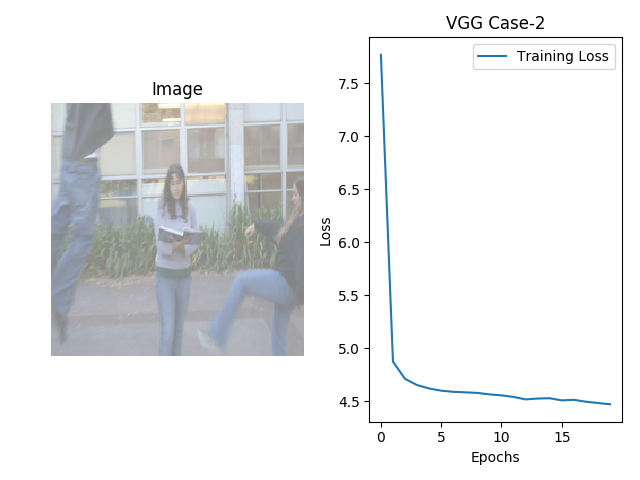

Start/Continue training from epoch 20


/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

In [6]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import torchvision as tv
from PIL import Image
import nntools as nt
import matplotlib.pyplot as plt
from dataloader import VOCDataset, myimshow
import model
import glob
from torch.autograd import Variable
class statsmanager(nt.StatsManager):
    def __init__self():
        super(statsmanager,self).__init__()

    def init(self):
        super(statsmanager,self).init()
        self.m_ap=0

    def accumulate(self,loss,x,y,d):
        #Do m_ap calculations
        super(statsmanager,self).accumulate(loss,x,y,d)
    

    def summarize(self):
        loss=super(statsmanager,self).summarize()
        return {'loss':loss}

def plot(self,fig,ax1, ax2 ,im):
    ax1.set_title('Image')
    x,y=train_set[0]
    myimshow(x,ax=ax1)
    ax2.set_title('VGG Case-2')
    ax2.plot([exp3.history[k][0]['loss']for k in range(exp3.epoch)],label='Training Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='best')
    plt.tight_layout()
    fig.canvas.draw()

lr=1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
vgg = model.VGGTransfer(20,16)
vgg.to(device)         
adam=torch.optim.Adam(vgg.parameters(),lr=lr)
stats_manager=statsmanager()
train_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/')
valid_set=VOCDataset('/datasets/ee285f-public/PascalVOC2012/', mode="val")
test_set=VOCDataset('/datasets/home/05/705/spalania/VOCdevkit/VOC2007', mode="test")
x,y=train_set[0]

exp3=nt.Experiment(vgg,train_set,valid_set,adam,stats_manager,batch_size=16,output_dir="run5",perform_validation_during_training=True)
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
exp3.load()

exp3.run(num_epochs=50,plot=lambda exp:plot(exp,fig=fig,ax1=ax1, ax2=ax2 ,im=x))



In [7]:
exp3.history

[({'loss': 7.766936083183747}, {'loss': 4.588582999238344}),
 ({'loss': 4.875442634755683}, {'loss': 4.436640985286867}),
 ({'loss': 4.712580730186127}, {'loss': 4.417030645679462}),
 ({'loss': 4.653964949227143}, {'loss': 4.386119846985719}),
 ({'loss': 4.621899690106014}, {'loss': 4.399232867350831}),
 ({'loss': 4.6011709574863655}, {'loss': 4.359230822863237}),
 ({'loss': 4.590505145420538}, {'loss': 4.378625282988741}),
 ({'loss': 4.585549485062725}, {'loss': 4.351921181812465}),
 ({'loss': 4.579951365894883}, {'loss': 4.365089336288309}),
 ({'loss': 4.5663314742621814}, {'loss': 4.3733164669940034}),
 ({'loss': 4.5570575118224035}, {'loss': 4.369849202046142}),
 ({'loss': 4.542495153933883}, {'loss': 4.3454741332389855}),
 ({'loss': 4.5189334263948}, {'loss': 4.390299075117735}),
 ({'loss': 4.527108436910428}, {'loss': 4.387260683600405}),
 ({'loss': 4.52996311486961}, {'loss': 4.3389937469149675}),
 ({'loss': 4.5098278923569435}, {'loss': 4.358482030321876}),
 ({'loss': 4.5152270

In [2]:
import os
import numpy as np
import torch
from torch import nn
import torch.utils.data as td
import torchvision as tv
import xml.etree.ElementTree as ET
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imread,imresize
import cv2

def decoder(pred):

    pred=pred.data
    pred=pred.squeeze(0)
    contain1 = pred[:,:,4].unsqueeze(2)
    contain2 = pred[:,:,9].unsqueeze(2)
    contain = torch.cat((contain1,contain2),2)
    mask1 = contain > 0.1 
    mask2 = (contain==contain.max())
    mask = (mask1+mask2).gt(0)
    boxes=[]
    cls_indexs=[]
    probs=[]
    for i in range(7):
        for j in range(7):
            for b in range(2):
                if mask[i][j][b]==1:
                    box = pred[i,j,b*5:b*5+4]
                    xc=pred[i,j,b*5]

                    w=pred[i,j,b*5+2]
                    yc=pred[i,j,b*5+1]
                    h=pred[i,j,b*5+3]
                    x_new = torch.FloatTensor([i])*(1./7)
                    y_new=torch.FloatTensor([j])*(1./7)
                    xc=xc*(1./7)+x_new
                    yc=yc*(1./7)+y_new
                    x1=(xc-(w/2))
                    x2=(xc+(w/2))
                    y1=(yc-(h/2))
                    y2=(yc+(h/2))   
                    bbox=torch.FloatTensor(box.size())
                    bbox[0]=x1
                    bbox[1]=y1
                    bbox[2]=x2
                    bbox[3]=y2
                    contain_prob=torch.FloatTensor([pred[i,j,b*5+4]])
                    max_prob,cls_index = torch.max(pred[i,j,10:],0)
                    if float((contain_prob*max_prob)[0]) > 0.1:
                        boxes.append(bbox.view(1,4))
                        cls_indexs.append(cls_index)
                        probs.append(contain_prob*max_prob)
    print(cls_indexs)
    if len(boxes)==0 or len(cls_indexs)==0:
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes,0) #(n,4)
        probs = torch.cat(probs,0) #(n,)
        cls_indexs = torch.stack(cls_indexs,0) #(n,)
    return boxes,probs,cls_indexs

In [3]:
voc_dict1 = {0:'person', 1:'bird', 2:'cat', 3:'cow', 4:'dog',5:'horse', 6:'sheep', 7:'aeroplane', 8:'bicycle',9:'boat', 10:'bus', 11:'car', 12:'motorbike', 13:'train', 14:'bottle', 15:'chair', 16:'diningtable', 17:'pottedplant', 18:'sofa', 19:'tvmonitor'}
path='/datasets/home/05/705/spalania/mAP/input/detection-results/'
img_path='/datasets/home/05/705/spalania/VOCdevkit/VOC2007/JPEGImages/'
for i in range(len(test_set)):
    x,y,z=test_set[i]
    print(z,i)
    x=x.view(1,3,224,224)
    x=x.to('cuda')
    op=vgg(x)
    op=op.view(7,7,30)
    a,b,c=decoder(op)
    img_path1=os.path.join(img_path,z+'.jpg')
    img = imread(img_path1)
    h,w,_=img.shape
    if a.shape[1]==1:
        a=a.view(1,4)
        b=b.view(1)
        c=c.view(1)
    a=a.detach().numpy()
    b=b.detach().numpy()
    c=c.to('cpu')
    c=c.detach().numpy()
    file_path=os.path.join(path,z+'.txt')
    f=open(file_path,'w')
    for j in range(len(a)):
        
        f.write(voc_dict1[c[j].item()]+' '+str(b[j].item())+' '+str(int(a[j][0].item()*w))+' '+str(int(a[j][1].item()*h))+' '+str(int(a[j][2].item()*w))+' '+str(int(a[j][3].item()*h)))
        f.write('\n')
    f.close()
    

007739 0
[tensor(0, device='cuda:0')]
003180 1
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000732 2
[]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


003246 3
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006518 4
[]
007358 5
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002874 6
[]
002406 7
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001513 8
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001961 9
[]
000886 10
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009818 11
[tensor

002522 75
[tensor(0, device='cuda:0')]
002950 76
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001437 77
[tensor(0, device='cuda:0')]
005529 78
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000277 79
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004657 80
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008630 81
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

004238 158
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000481 159
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000326 160
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009369 161
[tensor(0, device='cuda:0')]
001210 162
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007829 163
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tens

006964 226
[]
007420 227
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007852 228
[]
007387 229
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004947 230
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008552 231
[]
005375 232
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

005955 282
[tensor(0, device='cuda:0')]
000279 283
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005280 284
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007272 285
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006432 286
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006193 287
[tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006634 288
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005721 289
[]
001198

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004383 353
[tensor(0, device='cuda:0')]
009203 354
[tensor(0, device='cuda:0')]
001644 355
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000004 356
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003111 357
[]
009889 358
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000817 359
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device=

008088 427
[tensor(0, device='cuda:0')]
001016 428
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008059 429
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001760 430
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000687 431
[tensor(0, device='cuda:0')]
003035 432
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tens

008895 491
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004480 492
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008340 493
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007595 494
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007232 495
[tensor(7, device='cuda:0')]
008721 496
[tensor(0, device='cuda:0')]
005106 497
[tensor(7, device='cuda:0')]
000658 498
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006013 499
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005670 500
[]
004030 501
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

004665 567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002789 568
[tensor(0, device='cuda:0')]
007770 569
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003882 570
[]
003357 571
[tensor(0, device='cuda:0')]
002517 572
[tensor(0, device='cuda:0')]
004889 573
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009909 574
[tensor(0, device='cuda:0')]
007628 575
[]
003091 576
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003736 577
[tensor(0, device='cuda:0')]
006068 578
[]
000623 579
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

[tensor(7, device='cuda:0')]
005793 652
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008613 653
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008165 654
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009082 655
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009725 656
[tensor(0, device='cuda:0')]
003109 657
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007017 658
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009891 659
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005484 

004336 727
[]
004491 728
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006002 729
[tensor(0, device='cuda:0')]
004757 730
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008097 731
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005117 732
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000649 733
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009170 734
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009449 735
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001530 736
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, 

008666 816
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008110 817
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004177 818
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001629 819
[]
000069 820
[]
005737 821
[]
009750 822
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005883 823
[]
005356 824
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008571 825
[]
008903 826
[tensor(0, device='cuda:0')]
004964 827
[tensor

009564 887
[tensor(0, device='cuda:0')]
009916 888
[tensor(0, device='cuda:0')]
005503 889
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000988 890
[tensor(0, device='cuda:0')]
004343 891
[tensor(0, device='cuda:0')]
008324 892
[tensor(0, device='cuda:0')]
006077 893
[]
007190 894
[tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0')]
008745 895
[]
005162 896
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002822 897
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006688 898
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002031 899
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),

006856 981
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006383 982
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007264 983
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002948 984
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]
005943 985
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009924 986
[tensor(0, device='cuda:0')]
009556 987
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005296 988
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004068 1067
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008291 1068
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004923 1069
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009376 1070
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006204 1071
[tensor(0, device='cuda:0'), tensor(0, 

006823 1134
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008363 1135
[tensor(0, device='cuda:0')]
009951 1136
[]
005936 1137
[]
009284 1138
[tensor(0, device='cuda:0')]
005595 1139
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005232 1140
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0,

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006907 1206
[]
007492 1207
[tensor(0, device='cuda:0')]
007335 1208
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002819 1209
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008992 1210
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008247 1211
[]
009875 1212
[tensor(0, device='cuda:0')]
005460 1213
[tensor(0, device='cuda:0')]
002725 1214
[tensor(0, 

007248 1286
[]
000185 1287
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002177 1288
[tensor(0, device='cuda:0')]
003737 1289
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003041 1290
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002601 1291
[]
003387 1292
[tensor(7, device='cuda:0')]
003852 1293
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000292 1294
[tensor(0, device='cuda:0')]
009095 1295
[]
008172 1296
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004115 1297
[tensor(0, device='cuda:0')]
007000 1298
[tensor(0, dev

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007545 1372
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007937 1373
[]
002750 1374
[]
001645 1375
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002331 1376
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003571 1377
[tensor(11, device='cuda:0')]
003903 1378
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009888 1379
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda

006192 1456
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004501 1457
[]
008566 1458
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005341 1459
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003978 1460
[tensor(0, device='cuda:0')]
007866 1461
[]
007362 1462
[]
006522 1463
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005390 1464
[]
000369 1465
[tensor(0, device='cuda:0'), tensor(0, device='cuda

009313 1550
[]
003298 1551
[]
007386 1552
[tensor(2, device='cuda:0')]
004155 1553
[]
006600 1554
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003467 1555
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003815 1556
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
002580 1557
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002227 1558
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001495 1559
[]
000572 1560
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007118 15

005982 1635
[]
008802 1636
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004865 1637
[tensor(0, device='cuda:0')]
004417 1638
[tensor(0, device='cuda:0')]
001349 1639
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007502 1640
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006897 1641
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006342 1642
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008011 1643
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

004541 1707
[tensor(0, device='cuda:0')]
004933 1708
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008954 1709
[]
009366 1710
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005301 1711
[tensor(0, device='cuda:0')]
003938 1712
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008147 1713
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007792 1714
[]
006675 1715
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002252 1716
[tensor(0, device='cuda:0')]
004419 1717
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001347 1718
[tensor(0, device='cuda:0')]


008405 1785
[tensor(0, device='cuda:0')]
002229 1786
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007577 1787
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006490 1788
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009183 1789
[tensor(0, device='cuda:0')]
009624 1790
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

007107 1867
[tensor(7, device='cuda:0')]
009635 1868
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000392 1869
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004959 1870
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001275 1871
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002360 1872
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007399 1873
[tensor(0, dev

003375 1934
[tensor(0, device='cuda:0')]
005299 1935
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000260 1936
[tensor(7, device='cuda:0'), tensor(7, device='cuda:0')]
009559 1937
[]
001852 1938
[tensor(0, device='cuda:0')]
004408 1939
[tensor(0, device='cuda:0')]
001356 1940
[tensor(0, device='cuda:0')]
001883 1941
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006888 1942
[tensor(7, device='cuda:0')]
002243 1943
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002996 1944
[]
001737 1945
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001090 1946
[]
002622 1947
[tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004711 2014
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007604 2015
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006044 2016
[]
001389 2017
[tensor(0, device='cuda:0')]
009925 2018
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005942 2019
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001034 2096
[tensor(7, device='cuda:0')]
000674 2097
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005939 2098
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008868 2099
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006328 2100
[tensor(0, device='cuda:0')]
003804 2101
[tensor(0, device='cuda:0')]
003476 2102
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002236 2103
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002591 2104
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, devi

002203 2177
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002907 2178
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002575 2179
[tensor(0, device='cuda:0')]
000587 2180
[tensor(0, device='cuda:0')]
001812 2181
[tensor(0, device='cuda:0')]
000641 2182
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000378 2183
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005426 2184
[]
009441 2185
[tensor(0, device='cuda:0')]
005381 2186
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007769 2258
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(16, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002790 2259
[]
003677 2260
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000762 2261
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001122 2262
[tensor(0, device='cuda:0')]
000014 2263
[]
003101 2264
[tensor(0, device='cuda:0'), tensor(

009055 2337
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005795 2338
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006127 2339
[]
006680 2340
[]
006651 2341
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(

009176 2412
[tensor(0, device='cuda:0')]
004751 2413
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008736 2414
[tensor(0, device='cuda:0')]
007644 2415
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003263 2416
[]
002851 2417
[tensor(0, device='cuda:0')]
004268 2418
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001291 2419
[]
000376 2420
[]
005428 2421
[]
003602 2422
[]
005049 2423
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001157 2424
[]
008118 2425
[]
001621 2426
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005098 2427
[]
003174 2428
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002093 2429
[]
008579 2430
[]
007879 2431
[tensor(7, device='cuda:0')]
003515 2432
[]
003967 2433
[tensor(0, device='cu

[]
004132 2489
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004695 2490
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005772 2491
[tensor(0, device='cuda:0')]
009715 2492
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003139 2493
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007027 2494
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007780 2495
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0,

[]
004802 2566
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001489 2567
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009257 2568
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(11, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tenso

006116 2623
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007756 2624
[tensor(0, device='cuda:0')]
002008 2625
[]
008183 2626
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004308 2627
[tensor(0, device='cuda:0')]
001824 2628
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001456 2629
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000216 2630
[tensor(0, device='cuda:0')]
005548 2631
[tensor(0, device='cuda:0')]
002543 2632
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


[]
007607 2724
[tensor(0, device='cuda:0')]
002159 2725
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004712 2726
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005152 2727
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009135 2728
[tensor(0, device='cuda:0')]
009643 2729
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004064 2730
[]
008003 2731
[tensor(2, device='cuda:0')]
007171 2732
[tensor(0, 

005974 2808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005506 2809
[tensor(0, device='cuda:0')]
000258 2810
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008321 2811
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004893 2812
[tensor(0, device='cuda:0')]
008486 2813
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005798 2814
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002793 2815
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008906 2890
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004513 2891
[]
002358 2892
[tensor(0, device='cuda:0')]
007406 2893
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007874 2894
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006993 2895
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006246 2896
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004172 2897
[]
005095 2898
[tensor(7, device='cuda:0')]
003179 2899
[tensor(0, device='cuda:0')]
007067 2900
[tensor(0, de

000375 2969
[]
001535 2970
[]
001947 2971
[tensor(0, device='cuda:0')]
002852 2972
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006248 2973
[tensor(0, device='cuda:0')]
003964 2974
[]
002883 2975
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002356 2976
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001996 2977
[]
001243 2978
[tensor(0, device='cuda:0')]
008908 2979
[]
007069 2980
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006629 2981
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000062 2982
[]
003432 2983
[]
003840 2984
[]
001367 2985
[tensor(0, device='cuda:0')]
000955 

009390 3049
[]
009341 3050
[tensor(7, device='cuda:0')]
000478 3051
[tensor(0, device='cuda:0')]
004914 3052
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001238 3053
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008501 3054
[tensor(0, device='cuda:0')]
007801 3055
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007473 3056
[tensor(2, device='cuda:0')]
006594 3057
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001659 3058
[tensor(7, device='cuda:0')]
004107 3059
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009720 3060
[te

001634 3136
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(15, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000074 3137
[tensor(0, device='cuda:0')]
002057 3138
[]
006149 3139
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cud

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009736 3209
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005751 3210
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008176 3211
[]
008600 3212
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cud

001924 3293
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004208 3294
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000316 3295
[tensor(7, device='cuda:0')]
000188 3296
[tensor(0, device='cuda:0')]
004731 3297
[]
004096 3298
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007183 3299
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006064 3300
[tensor(0, device='cuda:0')

009485 3373
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000869 3374
[]
009322 3375
[]
005083 3376
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005724 3377
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008675 3378
[tensor(0, device='cuda:0')]
006147 3379
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003619 3380
[tensor(0, device='cuda:0')]
002059 3381
[]
007707 33

006604 3452
[tensor(7, device='cuda:0')]
005711 3453
[]
004151 3454
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008136 3455
[]
006265 3456
[tensor(0, device='cuda:0')]
007382 3457
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004942 3458
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008925 3459
[tensor(0, device='cuda:0')]
004297 3460
[tensor(0, device='cuda:0')]
009317 3461
[]
000389 3462
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005649 3463
[tensor(0, device='cuda:0')

003540 3530
[tensor(0, device='cuda:0')]
003079 3531
[]
006080 3532
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002639 3533
[tensor(0, device='cuda:0')]
004072 3534
[]
008015 3535
[tensor(0, device='cuda:0')]
005632 3536
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002258 3537
[tensor(0, device='cuda:0')]
003418 3538
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009234 3539
[tensor(0, device='cuda:0')]
009593 3540
[tensor(0, device='cuda:0')]
005986 3541
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]


008981 3595
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004233 3596
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007326 3597
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006566 3598
[]
003238 3599
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008192 3600
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009075 3601
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005012 3602
[tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0')]
003659 3603
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007747 3604
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), 

000852 3679
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009319 3680
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004299 3681
[]
003535 3682
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006752 3683
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007112 3684
[]
004007 3685
[tensor(0, device='cuda:0')]
000119 3686
[tensor(0, device='cuda:0')]
007573 3687
[tensor(0, device='cuda:0'), tensor(0, d

000018 3758
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007556 3759
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006316 3760
[tensor(0, device='cuda:0')]
003448 3761
[tensor(2, device='cuda:0')]
009264 3762
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008383 3763
[tensor(2, device='cuda:0')]
004443 3764
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003029 3765
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007690 3766
[]
007137 3767
[

001366 3845
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000281 3846
[]
003394 3847
[tensor(0, device='cuda:0')]
003841 3848
[tensor(0, device='cuda:0')]
005619 3849
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004059 3850
[tensor(0, device='cuda:0')]
002612 3851
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003052 3852
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003724 3853
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

007634 3934
[tensor(0, device='cuda:0')]
004340 3935
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008480 3936
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005500 3937
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005972 3938
[]
009915 3939
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006415 3940
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, d

008889 4007
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004602 4008
[]
009025 4009
[tensor(0, device='cuda:0')]
009782 4010
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006157 4011
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007717 4012
[tensor(0, device='cuda:0')]
009444 4013
[]
002428 4014
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003268 4015
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007400 4016
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007392 4084
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008935 4085
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008547 4086
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004952 4087
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000399 4088
[]
009803 4089
[tensor(0, device='cuda:0'), tensor(0, device='cuda:

003581 4170
[tensor(0, device='cuda:0')]
003226 4171
[tensor(0, device='cuda:0')]
002814 4172
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007338 4173
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001573 4174
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000333 4175
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007759 4176
[]
002007 4177
[]
003647 4178
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006119 4179
[tensor(0, device='cuda:0')]
005935 4180
[]
009952 4181
[]
001459 4182
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006820 4183
[tensor(0, device='cuda:0')

[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002993 4243
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005774 4244
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004134 4245
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008153 4246
[tensor(0, device='cuda:0')]
006200 4247
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007440 4248
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
007832 4249
[tensor(0, device='cuda:0'), tensor(10, device='cuda:0'), tensor(0, d

005540 4314
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009146 4315
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001798 4316
[]
007674 4317
[]
006793 4318
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006034 4319
[]
006742 4320
[]
007102 4321
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008070 4322
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009630 4323
[]
000568 4324
[tensor(0, device='cuda:0')]
001328 4325
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda

003366 4375
[tensor(0, device='cuda:0')]
002526 4376
[tensor(0, device='cuda:0')]
007278 4377
[]
002147 4378
[tensor(0, device='cuda:0')]
003707 4379
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006059 4380
[tensor(0, device='cuda:0')]
004249 4381
[]
001965 4382
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008589 4383
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000357 4384
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005409 4385
[tensor(0, device='cuda:0'), tensor(0, dev

008193 4459
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005013 4460
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009074 4461
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004125 4462
[]
007797 4463
[]
007030 4464
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003689 4465
[]
009363 4466
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006211 4467
[tensor(0, device='cuda:0')]
007823 4468
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006728 4469
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003076 4470

006081 4546
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
002638 4547
[tensor(0, device='cuda:0')]
005987 4548
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009592 4549
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005252 4550
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009235 4551
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

008641 4623
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004181 4624
[]
009001 4625
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
005066 4626
[]
009777 4627
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
008924 4628
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004531 4629
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000388 4630
[tensor(0, device='cuda:0')]
009188 4631
[tensor(0, device='cuda:0')]
000116 4632
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')

003457 4711
[]
003825 4712
[tensor(0, device='cuda:0')]
002217 4713
[tensor(0, device='cuda:0')]
007549 4714
[tensor(0, device='cuda:0')]
001302 4715
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000930 4716
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000542 4717
[tensor(0, device='cuda:0')]
002676 4718
[tensor(0, device='cuda:0')]
003036 4719
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001763 4720
[]
009483 4721
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, dev

005898 4800
[tensor(0, device='cuda:0')]
000861 4801
[tensor(0, device='cuda:0')]
000413 4802
[tensor(0, device='cuda:0')]
002080 4803
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003167 4804
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
006639 4805
[]
001195 4806
[tensor(0, device='cuda:0')]
000704 4807
[]
005849 4808
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000365 4809
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001957 4810
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001525 4811
[tensor(7, device='cuda:0'), tensor(0, device='cuda:0')]


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
009380 4891
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
000627 4892
[tensor(0, device='cuda:0')]
004739 4893
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001067 4894
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
003095 4895
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
001874 4896
[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0')]
004358 4897
[]
003353 489